# 1. Data Pre-Processing 

In [4]:
import warnings
warnings.filterwarnings('ignore')

# Dependencies
import os 
import urllib
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np 
import random
import cv2
from tqdm import tqdm
import math
from datetime import datetime
import shutil
import imghdr

# Building model
import tensorflow as tf 
import tensorflow_io as tfio
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import relu, sigmoid, softmax, tanh
from tensorflow.keras.layers import Conv2D, Dense, Flatten, BatchNormalization, MaxPool2D,Dropout, Add, AveragePooling2D
from tensorflow.keras.metrics import Recall, Accuracy, Precision
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, LearningRateScheduler,  ReduceLROnPlateau, TensorBoard


# Image augmentation 
import albumentations as A

2022-05-27 22:12:00.037297: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/zalven/anaconda3/envs/music-genre/lib/python3.7/site-packages/cv2/../../lib64:
2022-05-27 22:12:00.037339: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# 1. Data pre-processing

* 1.0 Data exploration
* 1.1 Data Splitting (Train, Test, Validation)   Data Augmentation
* 1.2 Data Augmentation
* 1.3 Data Preparation

## 1.0 Data Exploration

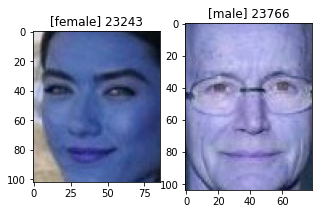

In [5]:
# Hype Paramters
DATA = os.path.join('data', 'Training')
CLASSES = os.listdir(DATA)
DATASET = 'dataset'
TRAINING_SET = os.path.join(DATASET, 'training')
TESTING_SET = os.path.join(DATASET, 'testing')
AUGMENTATION_MULTIPLIER = 3


def view_train_images():
      
    f, axarr = plt.subplots(nrows=1,ncols=len(CLASSES ), figsize=(5,5))
    for idx,category in enumerate(CLASSES):
          
      # path to the image
      images_path = os.path.join(DATA,category )
      images = os.listdir(images_path )
      example_img_path = os.path.join(images_path,random.choice( images ) )
      example_img = img.imread( example_img_path )

      # Plot example images 
      axarr[idx].set_title(f'[{category}] {len(images)}' )
      axarr[idx].imshow(cv2.cvtColor(example_img, cv2.COLOR_BGR2RGB) )
      
view_train_images()

## 1.1 Data Splitting and Data Augmentation

In [10]:
def random_uniuqe_image_name():
    return f'{datetime.timestamp(datetime.now())}.jpg'
def data_augmentation(file_dir, save_dir):
    # Reading the image 
    image = cv2.imread(file_dir ,cv2.COLOR_BGR2RGB)
    img_array = cv2.resize( image, (50,50)) 
    
    # Save original image name 
    file_path = os.path.join(save_dir, random_uniuqe_image_name())
    cv2.imwrite(file_path, img_array )
    
    
    # Data augmentation with multiplier 
    for _ in range(AUGMENTATION_MULTIPLIER):
        transform = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.2),
            A.ShiftScaleRotate(),
            A.OpticalDistortion(),
            A.RandomScale(),
            A.GridDistortion(),
            A.RandomGamma(),
        ])
        transformed = transform(image=img_array )
        img_array_resize = cv2.resize(  transformed["image"], (50,50)) 
        file_path = os.path.join(save_dir, random_uniuqe_image_name())
        cv2.imwrite(file_path, img_array_resize )
        
        
# Remvoe folder and create empty folder 
if os.path.exists(DATASET): 
    shutil.rmtree(DATASET, ignore_errors=True)
        
# Train 80% , Test 20%
for idx,category in enumerate(CLASSES):
    # path to the image
    images_path = os.path.join(DATA,category )
    list_images = os.listdir(images_path) 
    train_count = int(len(list_images)*0.80)
    
    train_images = list_images[:train_count]
    test_images = list_images[train_count:]
    
    training_set = os.path.join(TRAINING_SET, category)
    testing_set = os.path.join(TESTING_SET, category) 
    os.makedirs(training_set)
    os.makedirs(testing_set)
    
    for train_image_name in train_images:
        train_image_dir = os.path.join(images_path ,train_image_name)
        # Check if image 
        if imghdr.what(train_image_dir).lower().endswith(('png', 'jpg', 'jpeg', 'tiff', 'bmp', 'gif')):
            data_augmentation(train_image_dir, training_set )
    
    for test_image_name in test_images:
        test_image_dir = os.path.join(images_path ,test_image_name)
        # Check if image 
        if imghdr.what(test_image_dir).lower().endswith(('png', 'jpg', 'jpeg', 'tiff', 'bmp', 'gif')):
            data_augmentation(test_image_dir, testing_set )
        

In [6]:
for col in CLASSES :
    testing_set = os.path.join(TESTING_SET, col)
    test_images = os.listdir(testing_set)
    print(f'Testing {col} : {len(test_images)}')
    
for col in CLASSES :
    training_set = os.path.join(TRAINING_SET, col)
    train_images = os.listdir(training_set)
    print(f'Training {col} : {len(train_images)}')

Testing female : 18596
Testing male : 19016
Training female : 74376
Training male : 76048


## 1.3 Data Preparation

In [7]:
# Train data 
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    TRAINING_SET,
    target_size=(50,50),
    batch_size=32,
    shuffle=True,
    color_mode='grayscale',
    class_mode='categorical'
)

# Test data 
test_dataget = ImageDataGenerator(rescale=1./255)
test_generator = train_datagen.flow_from_directory(
    TESTING_SET ,
    target_size=(50,50),
    batch_size=32,
    shuffle=True,
    color_mode='grayscale',
    class_mode='categorical'
)

Found 150424 images belonging to 2 classes.
Found 37612 images belonging to 2 classes.


# 2. Convolutional Neural Network

* 2.0 Creating Callbacks
* 2.1 Create and Compile Deep neural Network
* 2.2 Fitting Neural Network

## 2.0 Creating Callbacks

In [8]:
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=50, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='concrete_model.h5', monitor='val_loss', verbose=1, save_best_only=True)
his = CSVLogger( 'history.csv', separator=',', append=False)
tb = TensorBoard('logs')

callbacks = [ es, rlr, mcp, his, tb ]


## 2.1 Create and Compile Deep Neural Network


In [9]:
# Whole or broken grain thesis paper NEU 2021 used model
def NEU_CCS2021_RICE_GRAIN(shape, classes):
  # Layer 0 
  x_input = tf.keras.layers.Input(shape)
  x = tf.keras.layers.ZeroPadding2D((3, 3))(x_input)

  # Layer 1
  x = Conv2D(filters=10, kernel_size = (16,16), activation='relu', strides=1)(x)
  x = BatchNormalization(axis=3)(x)
  x = MaxPool2D(pool_size=(3,3), strides=3)(x)
  
  # Layer 2 
  x = Conv2D(50, kernel_size=(8,8), activation='relu', strides=1)(x)
  x = BatchNormalization(axis=3)(x)
  x = MaxPool2D(pool_size=(2,2),strides=2)(x)
  
  # Layer 4 
  x =  Conv2D(filters=126, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(x)
  x =  BatchNormalization()(x)
  x =  MaxPool2D(pool_size=(3,3), strides=(2,2))(x)

  # Layer 5 
  x = tf.keras.layers.AveragePooling2D((2,2), padding = 'same')(x)
  x =  Flatten()(x)
  x = Dense(2048, activation='relu')(x)
  x = Dropout(0.2)(x)
  
  # Layer 6 
  x = Dense(2048, activation='relu')(x)
  x = Dropout(0.2)(x)

  # Output layer
  x = Dense(classes, activation='sigmoid')(x)
  model = tf.keras.models.Model(inputs = x_input, outputs = x, name = "NEUCSS-modification")
  return model 

model = NEU_CCS2021_RICE_GRAIN(shape=(50,50,1), classes=len(CLASSES))
model.compile(
    loss=categorical_crossentropy,
    optimizer=Adam(learning_rate=0.03),
    metrics=['accuracy'],
)
model.summary()

Model: "NEUCSS-modification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 50, 1)]       0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 56, 56, 1)        0         
 2D)                                                             
                                                                 
 conv2d (Conv2D)             (None, 41, 41, 10)        2570      
                                                                 
 batch_normalization (BatchN  (None, 41, 41, 10)       40        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 10)       0         
 )                                                               
                                               

2022-05-27 22:12:27.128702: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/zalven/anaconda3/envs/music-genre/lib/python3.7/site-packages/cv2/../../lib64:
2022-05-27 22:12:27.128734: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-27 22:12:27.128753: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (zalven-Nitro-AN515-55): /proc/driver/nvidia/version does not exist
2022-05-27 22:12:27.129228: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

## 2.22 Fitting Neural Network

In [10]:
%%time
history = model.fit(
    train_generator,
    validation_data=test_generator,
    shuffle=True, 
    epochs=100,
    callbacks=callbacks, 
    verbose=1, batch_size=256
)

Epoch 1/100


2022-05-27 22:12:35.310182: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 16777216 exceeds 10% of free system memory.
2022-05-27 22:12:35.328307: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 16777216 exceeds 10% of free system memory.


 177/4701 [>.............................] - ETA: 10:20 - loss: 24.5360 - accuracy: 0.5403

KeyboardInterrupt: 